## Relevant Libraries

In [13]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

Matplotlib is building the font cache; this may take a moment.


## Connect to Postgre

In [3]:
load_dotenv()

# PostgreSQL Configuration
db_params = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "sslmode": os.getenv("DB_SSLMODE")
}

conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

# Get list of tables in public schema
cursor.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public'
""")
tables = cursor.fetchall()

# Dictionary to hold DataFrames
table_data = {}

for (table_name,) in tables:
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    table_data[table_name] = df

cursor.close()
conn.close()


C:\Users\GIDI\AppData\Local\Temp\ipykernel_4252\705200099.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


## Drivers Table

In [4]:
drivers= table_data['drivers']
drivers.head()

,driver_id,rating,vehicle_type,signup_date,last_active,city,acceptance_rate
0,D00000,3.1,SUV,2025-01-20,2025-01-06 18:23:09,Cairo,0.679555
1,D00001,5.0,Sedan,2023-03-27,2025-04-27 01:44:02,Nairobi,0.548786
2,D00002,4.5,Motorcycle,2024-05-02,2025-03-07 19:24:46,Nairobi,0.593724
3,D00003,5.0,Motorcycle,2023-04-16,2025-03-26 19:16:24,Nairobi,0.990000
4,D00004,4.4,Motorcycle,2023-05-28,2025-04-08 18:54:45,Lagos,0.519773


## Inspection and Data Cleaning

In [5]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driver_id        5000 non-null   object 
 1   rating           5000 non-null   float64
 2   vehicle_type     5000 non-null   object 
 3   signup_date      5000 non-null   object 
 4   last_active      5000 non-null   object 
 5   city             5000 non-null   object 
 6   acceptance_rate  5000 non-null   float64
dtypes: float64(2), object(5)
memory usage: 273.6+ KB


No missing values. The dataset has 5000 rows and 7 columns.

In [6]:
# Check unique elements in each column and print them out
for column in drivers.columns:
    unique_values = drivers[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'driver_id':
['D00000' 'D00001' 'D00002' ... 'D04997' 'D04998' 'D04999']

Unique values in 'rating':
[3.1 5.  4.5 4.4 3.7 4.6 3.3 4.1 3.8 4.9 3.4 4.7 4.2 4.8 3.5 3.6 4.3 4.
 3.9 3.2]

Unique values in 'vehicle_type':
['SUV' 'Sedan' 'Motorcycle' 'Luxury']

Unique values in 'signup_date':
['2025-01-20' '2023-03-27' '2024-05-02' ... '2025-01-08' '2022-11-14'
 '2023-04-01']

Unique values in 'last_active':
['2025-01-06 18:23:09' '2025-04-27 01:44:02' '2025-03-07 19:24:46' ...
 '2025-04-16 08:52:21' '2025-04-06 03:43:05' '2025-02-09 05:47:23']

Unique values in 'city':
['Cairo' 'Nairobi' 'Lagos']

Unique values in 'acceptance_rate':
[0.67955484 0.5487857  0.59372375 ... 0.82724354 0.5201239  0.68538236]



categorical=['vehicle_type','city']

In [7]:
# Convert object columns to 'category' type
category_columns = ['vehicle_type', 'city']
for col in category_columns:
    drivers[col] = drivers[col].astype('category')

# Convert date columns to datetime
date_columns = ['signup_date', 'last_active']
for col in date_columns:
    drivers[col] = pd.to_datetime(drivers[col])

# Check the updated data types
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   driver_id        5000 non-null   object        
 1   rating           5000 non-null   float64       
 2   vehicle_type     5000 non-null   category      
 3   signup_date      5000 non-null   datetime64[ns]
 4   last_active      5000 non-null   datetime64[ns]
 5   city             5000 non-null   category      
 6   acceptance_rate  5000 non-null   float64       
dtypes: category(2), datetime64[ns](2), float64(2), object(1)
memory usage: 205.5+ KB


In [8]:
# Checking for duplicates
drivers.duplicated().sum()

0

In [12]:
drivers.describe()

,rating,signup_date,last_active,acceptance_rate
count,5000.000000,5000,5000,5000.000000
mean,4.172440,2023-10-24 01:58:22.080000,2025-03-07 13:50:29.265600,0.695318
min,3.100000,2022-04-27 00:00:00,2022-04-28 16:45:24,0.100000
25%,3.700000,2023-01-18 18:00:00,2025-03-13 08:03:29.750000128,0.565169
50%,4.200000,2023-10-20 00:00:00,2025-04-08 11:24:16.500000,0.697731
75%,4.700000,2024-07-28 00:00:00,2025-04-19 19:19:43,0.837700
max,5.000000,2025-04-26 00:00:00,2025-04-27 16:20:56,0.990000
std,0.594073,NaN,NaN,0.186216


### Driver Performance & Engagement Analysis

This analysis explores key metrics from a ride-hailing driver dataset with 5,000 entries. The focus is on driver ratings, signup activity, recent engagement, and acceptance behavior.

---

### 1. Driver Ratings

- **Mean rating:** 4.17  
- **Min rating:** 3.1  
- **Max rating:** 5.0  
- **Standard Deviation:** 0.59  
- **75th percentile:** 4.7

**Insight:**  
Most drivers are rated highly, with 75% having a rating of 4.7 or lower. The distribution is skewed toward higher ratings, indicating overall good performance. However, some outliers on the lower end (as low as 3.1) may need performance reviews or customer feedback follow-ups.

---

### 2. Signup Date Distribution

- **Earliest signup:** April 27, 2022  
- **Latest signup:** April 26, 2025  
- **Median signup date:** October 20, 2023

**Insight:**  
Drivers have been joining the platform steadily over the past three years. The median indicates most drivers joined in late 2023, showing recent growth in onboarding efforts.

---

### 3. Last Active Date

- **Earliest last active:** April 28, 2022  
- **Latest last active:** April 27, 2025  
- **Median last active date:** April 8, 2025

**Insight:**  
The majority of drivers are still active or were active recently. The platform appears to have a healthy retention rate with a strong proportion of active drivers as of 2025.

---

### 4. Acceptance Rate

- **Mean acceptance rate:** 69.5%  
- **Min:** 10%  
- **Max:** 99%  
- **Median:** 69.8%

**Insight:**  
Most drivers have moderate to high acceptance rates, reflecting general responsiveness to ride requests. However, a few drivers have very low acceptance rates, which could indicate part-time engagement or selective behavior.

---

### 📌 Summary

- The platform is expanding with new drivers.
- Ratings and engagement metrics show strong performance.
- Some drivers may require performance coaching or deeper review based on low ratings or low acceptance behavior.



## Distribution

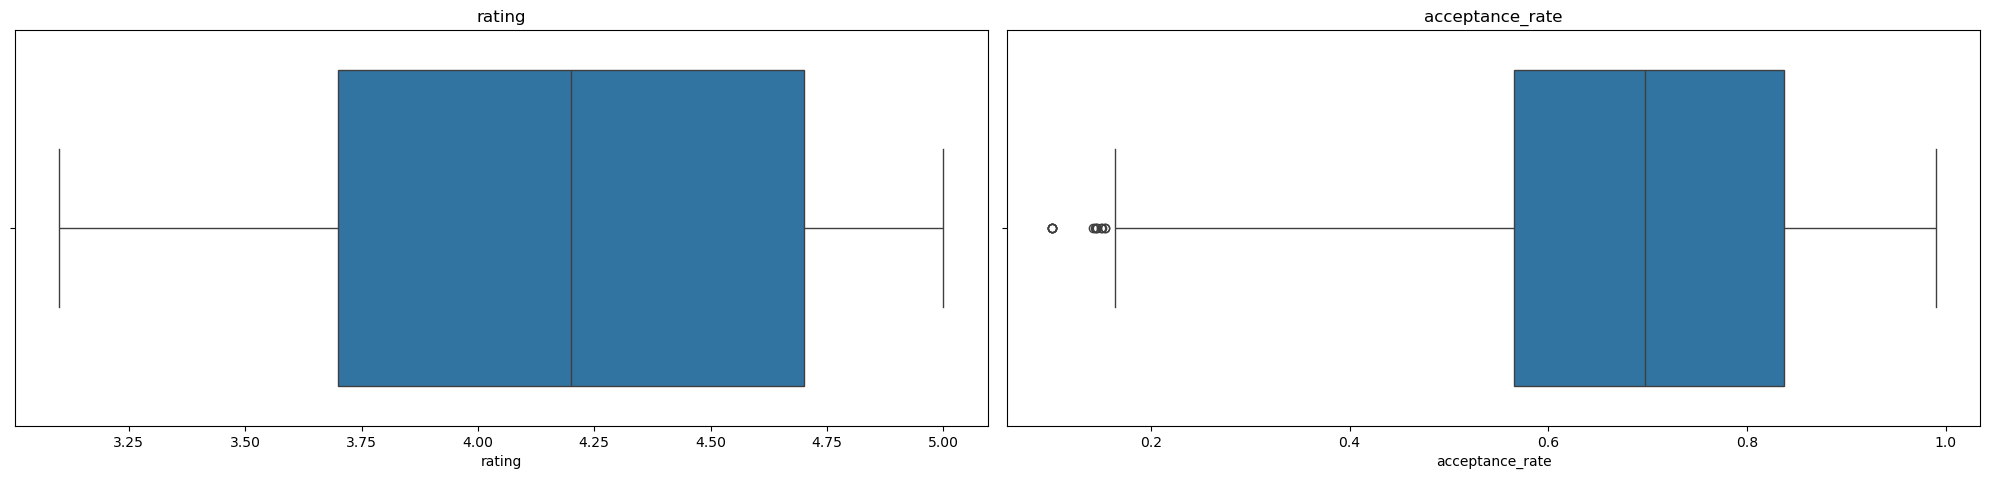

In [14]:
#Get names of all numerical feature
num_vars=drivers.select_dtypes(include=['int','float']).columns.tolist()

# Create a figure with subplots

num_cols=len(num_vars)
num_rows = num_cols
fig,axes=plt.subplots(nrows=num_cols,ncols=2,figsize=(20,4.5*num_rows))
axes=axes.flatten()

# Create a countplot for the top 6  values 
for i, var in enumerate(num_vars):
    sns.boxplot(x=drivers[var],ax=axes[i])
    axes[i].set_title(var)
    
# Remove any extra empty subplots if needed
if num_cols < len(axes):
    for i in range(num_cols,len(axes)):
        fig.delaxes(axes[i])
        
# Adjust spacing  between subplots
fig.tight_layout()


## Exploratory Data Analysis

In [15]:
# Create a copy for analysis
df_analysis = drivers.copy()

In [16]:
# New features
df_analysis["days_active"] = (df_analysis["last_active"] - df_analysis["signup_date"]).dt.days
df_analysis["year_signed_up"] = df_analysis["signup_date"].dt.year
df_analysis["month_signed_up"] = df_analysis["signup_date"].dt.month

In [ ]:
# Count of drivers per city
drivers_per_city = df_analysis["city"].value_counts()

# Average acceptance rate and rating by city
city_grouped = df_analysis.groupby("city")[["acceptance_rate", "rating"]].mean()



### Which vehicle type has the highest driver acceptance rate?

C:\Users\GIDI\AppData\Local\Temp\ipykernel_4252\1925441017.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_acceptance = df_analysis.groupby('vehicle_type')['acceptance_rate'].mean().sort_values(ascending=False).reset_index()
C:\Users\GIDI\AppData\Local\Temp\ipykernel_4252\1925441017.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='vehicle_type', y='acceptance_rate', data=mean_acceptance, ci=None, order=mean_acceptance['vehicle_type'])


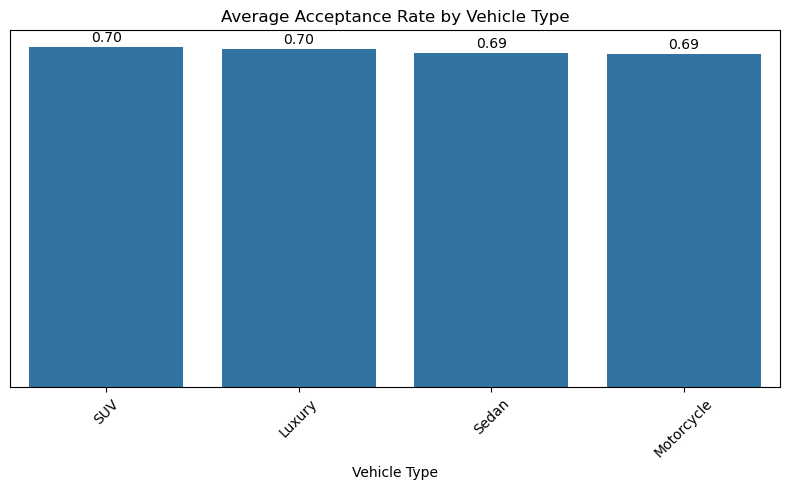

In [20]:
# Calculate mean acceptance rate by vehicle_type and sort descending
mean_acceptance = df_analysis.groupby('vehicle_type')['acceptance_rate'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 5))

# Plot barplot without error bars by setting ci=None, use the sorted order
ax = sns.barplot(x='vehicle_type', y='acceptance_rate', data=mean_acceptance, ci=None, order=mean_acceptance['vehicle_type'])

plt.title("Average Acceptance Rate by Vehicle Type")

plt.xlabel("Vehicle Type")
plt.ylabel("")  # Remove y-axis label

# Hide y-axis ticks and line
ax.yaxis.set_visible(False)

plt.xticks(rotation=45)

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.01, f'{height:.2f}', ha="center")

plt.tight_layout()
plt.show()

In [ ]:



# Plot: Acceptance rate by vehicle type
plt.figure(figsize=(8, 5))
sns.boxplot(x="vehicle_type", y="acceptance_rate", data=df_analysis)
plt.title("Acceptance Rate by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Acceptance Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Days Active Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_analysis["days_active"], bins=10, kde=True, color="lightgreen")
plt.title("Driver Days Active Since Signup")
plt.xlabel("Days Active")
plt.tight_layout()
plt.show()

# Optional: City-level barplot for average rating and acceptance
plt.figure(figsize=(10, 5))
city_grouped.sort_values("acceptance_rate", ascending=False)["acceptance_rate"].plot(kind="bar", color="tomato")
plt.title("Average Acceptance Rate by City")
plt.ylabel("Acceptance Rate")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show analysis results
summary, unique_counts, drivers_per_city, city_grouped


In [4]:
table_data['promotions']

,promo_id,promo_name,promo_type,promo_value,start_date,end_date,target_segment,city_scope,ab_test_groups,test_allocation,success_metric
0,P000,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-25,All,Nairobi,['All'],[1.0],Usage Frequency
1,P001,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-22,All,Cairo,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",Conversion Rate
2,P002,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-16,All,Cairo,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",ROI
3,P003,Loyalty Bonus,points,100.0,2025-04-26,2025-05-04,Gold+,Nairobi,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",Conversion Rate
4,P004,Loyalty Bonus,points,100.0,2025-04-26,2025-05-15,Gold+,Nairobi,['All'],[1.0],Usage Frequency


In [5]:
table_data['riders']


,user_id,signup_date,loyalty_status,age,city,avg_rating_given,churn_prob,referred_by
0,R00000,2025-01-24,Bronze,34.729629,Nairobi,5.0,0.142431,R00001
1,R00001,2024-09-09,Bronze,34.571020,Nairobi,4.7,0.674161,None
2,R00002,2024-09-07,Bronze,47.133960,Lagos,4.2,0.510379,None
3,R00003,2025-03-17,Bronze,41.658628,Nairobi,4.9,0.244779,None
4,R00004,2024-08-20,Silver,40.681709,Lagos,3.9,0.269960,R00002


In [6]:
table_data['sessions']


,session_id,rider_id,session_time,time_on_app,pages_visited,converted,city,loyalty_status
0,S000000,R08605,2025-04-27 18:57:06+02:05,79,4,1,Cairo,Bronze
1,S000001,R08823,2025-04-27 07:32:22+02:27,101,3,0,Nairobi,Silver
2,S000002,R05342,2025-04-27 23:17:25+02:05,12,1,0,Cairo,Bronze
3,S000003,R05057,2025-04-27 14:40:25+00:14,19,1,0,Lagos,Silver
4,S000004,R09614,2025-04-27 08:31:22+00:14,4,1,0,Lagos,Bronze


In [7]:
table_data['trips']

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,weather,city,loyalty_status
0,T000000,R05207,D00315,12.11,1.0,0.00,Card,2024-11-27 18:41:50+02:27,2024-11-27 19:33:50+02:27,-1.108123,36.912209,-1.068155,36.875377,Foggy,Nairobi,Bronze
1,T000001,R09453,D03717,8.73,1.0,0.02,Card,2024-10-28 23:13:48+00:14,2024-10-28 23:26:48+00:14,6.675266,3.515740,6.641734,3.525620,Sunny,Lagos,Gold
2,T000002,R00567,D02035,19.68,1.0,0.00,Card,2025-02-17 05:36:41+02:27,2025-02-17 05:52:41+02:27,-1.248589,37.010668,-1.273182,37.018586,Cloudy,Nairobi,Bronze
3,T000003,R09573,D02657,16.43,1.0,0.01,Mobile Money,2024-06-18 19:27:14+02:05,2024-06-18 19:32:14+02:05,29.819554,31.188780,29.837689,31.232978,Cloudy,Cairo,Bronze
4,T000004,R03446,D01026,8.70,1.0,1.06,Card,2024-10-05 09:58:16+02:27,2024-10-05 10:28:16+02:27,-1.676479,36.729219,-1.638395,36.694063,Sunny,Nairobi,Gold
